# Ranking Warming Rates Behind Mask

Re-order warming rates following the masking of polar waters covered by ice extent. For expediency we've opted to remove data at the poles beyond 70N & 70S. Probably would be better to use an older ice-coverage dataset since it is declining, but this should work about the same.

In [31]:
# Libraries
import os
import xarray as xr
import oisstools as ot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


#### 1. Set workspace
workspace = "local"
box_root = ot.set_workspace("local")

# Specify path to ice extent
ice_path = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/Arctic_ice_cover/"

#### 2. Print Last Update
print(f"Working via directory at: {box_root}")

# Check that the root directory isn't broken
os. listdir('/Users/akemberling/Library/CloudStorage/') 

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


['.DS_Store', 'Box-Box']

# Load Data

Can load the existing warming rates file, and the ice coverage shapefile. The latter will need to be re-projected.

In [32]:
# Load the 1982-2023 warming rates file
rates_file = f"{box_root}RES_Data/OISST/oisst_mainstays/warming_rates/annual_warming_rates{1982}to{2023}.nc"
rates_ds = xr.open_dataset(rates_file)
rates_ds

<xarray.Dataset>
Dimensions:              (lon: 1440, lat: 720)
Coordinates:
  * lon                  (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat                  (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
Data variables:
    annual_warming_rate  (lat, lon) float64 ...
    rate_percentile      (lat, lon) float64 ...
Attributes:
    title:             Annual sea surface temperature warming rates from NOAA...
    institution:       Gulf of Maine Research Institute
    source:            NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:           Sea surface temperature averaged by year prior to use ...
    history:           Warming rates calculated 2024-01-30
    references:        https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.o...
    dataset_title:     GMRI Sea Surface Warming Rates and Rankings - OISST
    reference_period:  Rates and ranks calculated using years 1982 to 2023

<AxesSubplot:>

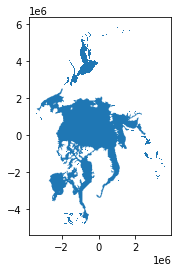

In [33]:
# Load the Sea Ice Coverage
# Source: U.S. National Ice Center
coverage_file = f"{ice_path}extent_N_202303_polygon_v3.0/extent_N_202303_polygon_v3.0.shp"
ice_shp = gpd.read_file(coverage_file)
ice_shp.plot()


## Re-project the ice coverage

This one is a little thorny because of how it wraps around the antimeridian

For an approach for how to handle this look here:
https://towardsdatascience.com/around-the-world-in-80-lines-crossing-the-antimeridian-with-python-and-shapely-c87c9b6e1513

epsg:3413


/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

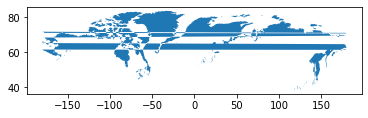

In [34]:
# view the coordinate reference system of both layers 
print(ice_shp.crs)

ice_wgs = ice_shp.to_crs({'init': 'epsg:4326'})
ice_wgs.plot()

## Perform the Masking

Going with a simpler approach

## OR, Just lose a general area above 70N

The area of sea ice cover fluctuates year to year, so any one year will be different

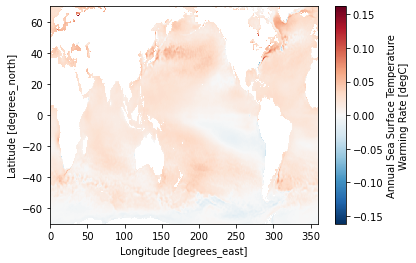

In [35]:
rates_noice = rates_ds.sel(lat = slice(-70,70)).load()
rates_noice.annual_warming_rate.plot()

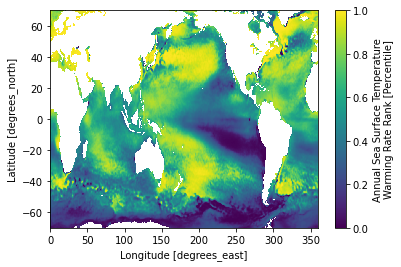

In [36]:
# Plot ranks
rates_noice.rate_percentile.plot()

## Re-order the warming percentiles

With the ice coverage removed the percentiles should shift slightly, so we want to account for that.

In [38]:
# Just need the rates here, and they need to be a numpy array
trends = rates_noice.annual_warming_rate.to_numpy()
trends

array([[-0.00562028, -0.00565955, -0.00588216, ..., -0.00544913,
        -0.00546162, -0.00558872],
       [-0.00597931, -0.00604767, -0.00625778, ..., -0.00553151,
        -0.00562853, -0.00586603],
       [-0.00632272, -0.00641269, -0.00651478, ..., -0.00611033,
        -0.00614861, -0.00626288],
       ...,
       [ 0.03151957,  0.03114278,  0.03078965, ...,  0.03297778,
         0.03232301,  0.03185494],
       [ 0.03045468,  0.03004392,  0.02970683, ...,  0.0322978 ,
         0.0314349 ,  0.03084554],
       [ 0.03007049,  0.02966726,  0.02942435, ...,  0.03208091,
         0.03111643,  0.03050576]])

In [40]:
# source: https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice

#### 1. Copy the trend values so we can change them without impacting originals
trends_rank = trends.copy()

#### 2. drop the NA values
# pull array of just non-nan values
trends_nona = trends_rank[~np.isnan(trends_rank)]

#### 3. order + rank them
order = trends_nona.argsort()
rank  = order.argsort()

#### 4. scale by max rank to get percentiles
max_rank = rank.max()
rank_norm = rank / max_rank
rank_norm

#### 5. Replace the non-NA values in trends_rank with the scaled ranks

# Order 
order_out = trends_rank.copy()
order_out[~np.isnan(order_out)] = order

# Their Rank as Percentile
rank_out = trends_rank.copy()
rank_out[~np.isnan(rank_out)] = rank_norm


## Reformat to Xarray Dataset and Validate it

Text(0.5, 1.0, 'Warming Rate Rankings')

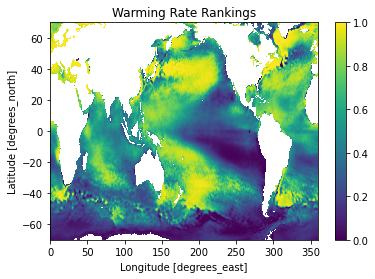

In [41]:
# We now have 2 more arrays, one with the order, the other with their ranks
order_xr = xr.DataArray(order_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = rates_noice.coords["lon"], lat = rates_noice.coords["lat"])
rank_xr  = xr.DataArray(rank_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = rates_noice.coords["lon"], lat = rates_noice.coords["lat"])

# Plot warming rate percentile ranks
rank_xr.plot() 
plt.title("Warming Rate Rankings")

## Export

In [53]:
# Make it an xarray Dataset
ranks_ds = rank_xr.to_dataset(name = "annual_warming_rate_percentile")


# Assign Attributes so people know what it is
rank_attrs = {
    'title'         : f'Annual sea surface temperature warming rate percentile ranks from NOAA OISSTv2 SST Data. Rates calculated from annual average SST for 1982-2023.',
    'institution'   : 'Gulf of Maine Research Institute',
    'source'        : 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
    'comment'       : f'Data has been masked to remove areas near the poles that experience sea ice coverage beyond 70N & 70S',
    'history'       : 'Percentiles calculated 2/15/2023',
    'references'    : 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
    'dataset_title' : 'Annual SST Warming Rank Percentile - OISSTv2',


  }

# Assign them
ranks_ds.attrs = rank_attrs
ranks_ds

# And again for the warming rate ranks?
rank_var_attrs = {
    'long_name'   : "Annual Sea Surface Temperature Warming Rate Rank",
    'units'       : "Percentile",
    'valid_range' : "array([0., 1.], dtype=float32)",
    'dataset'     : "NOAA High-resolution Blended Analysis",
    'var_desc'    : "Sea Surface Temperature",
    'level_desc'  : "Surface",
    'statistic'   : "Rank Percentile",
    'parent_stat' : "Annual Sea Surface Temperature Warming Rates"
}
ranks_ds.annual_warming_rate_percentile.attrs  = rank_var_attrs
ranks_ds

<xarray.Dataset>
Dimensions:                         (lon: 1440, lat: 560)
Coordinates:
  * lon                             (lon) float32 0.125 0.375 ... 359.6 359.9
  * lat                             (lat) float32 -69.88 -69.62 ... 69.62 69.88
Data variables:
    annual_warming_rate_percentile  (lat, lon) float64 0.0451 0.04459 ... 0.9042
Attributes:
    title:          Annual sea surface temperature warming rate percentile ra...
    institution:    Gulf of Maine Research Institute
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Data has been masked to remove areas near the poles that ...
    history:        Percentiles calculated 2/15/2023
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  Annual SST Warming Rank Percentile - OISSTv2

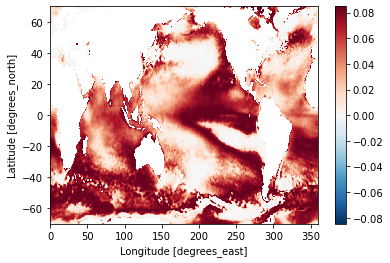

In [54]:
# What difference does it make
ranks_change = (rates_ds.rate_percentile - ranks_ds.annual_warming_rate_percentile)
ranks_change.plot()

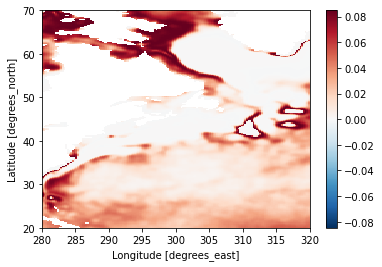

In [51]:
ranks_change.sel(lon = slice(280, 320), lat = slice(20, 70)).plot()

# Export

In [56]:
#trends_ds.to_netcdf('NSF OKN Demo Data/oisst/warming_rates/annual_warming_rates.nc')
export_file = f"{box_root}RES_Data/OISST/oisst_mainstays/warming_rates/OISST-non-polar-annual-warming-percentiles-to-2023.nc"
ranks_ds.to_netcdf(export_file)
print(f"Non-Polar Warming for period: 1982 to 2023")
print("Exported to: " + export_file)

Non-Polar Warming for period: 1982 to 2023
Exported to: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays/warming_rates/OISST-non-polar-annual-warming-percentiles-to-2023.nc
